In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append(f"./../")

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from typing import List, Tuple, Dict
from pathlib import Path
import random
import json

from src.qaoa_scheduling import QAOACircuit, QAOAScheduler

In [2]:
class QAOAAnalyzer:
    def __init__(self, n_vertices: int, g6_path: str, random_seed: int = None):
        if random_seed is not None:
            np.random.seed(random_seed)
        self.n_vertices = n_vertices
        self.g6_path = g6_path
        self.results_dir = Path("computed_results")
        self.results_dir.mkdir(exist_ok=True)

    def read_g6_graphs(self) -> List[nx.Graph]:
        """Read graphs from a g6 format file."""
        with open(self.g6_path, "rb") as f:
            graphs = list(nx.read_graph6(f))
        return graphs

    def analyze_graph(self, G: nx.Graph) -> Dict:
        """Analyze a single graph for QAOA scheduling metrics."""
        # Generate random gamma values in (0, 2π]
        gamma_gates = {
            (min(u, v), max(u, v)): np.random.uniform(low=0.0, high=2 * np.pi, size=1)[
                0
            ]
            for u, v in G.edges()
        }
        circuit = QAOACircuit(
            n_qubits=G.number_of_nodes(), gamma_gates=gamma_gates, beta_time=1.0
        )

        # Create scheduler and get results
        scheduler = QAOAScheduler(circuit)
        lp_result = scheduler.solve_lp()
        layered_result = scheduler.schedule_layered()

        seqt = lp_result.total_time_before
        layt = layered_result.total_time_after
        lpt = lp_result.total_time_after

        # Calculate improvement
        improvement_percentage = np.abs(lpt - layt) / layt

        return {"edges": G.number_of_edges(), "improvement": improvement_percentage}

    def get_result_path(self):
        """Get path for saving/loading results."""
        filename = f"results_v{self.n_vertices}.json"
        return self.results_dir / filename

    def save_results(self, edge_counts, means, stds):
        """Save results to JSON file."""
        results = {
            "n_vertices": self.n_vertices,
            "edge_counts": edge_counts,
            "means": means,
            "stds": stds,
        }
        with open(self.get_result_path(), "w") as f:
            # Convert numpy arrays to lists for JSON serialization
            results = {
                k: v.tolist() if isinstance(v, np.ndarray) else v
                for k, v in results.items()
            }
            json.dump(results, f)

    def load_results(self):
        """Load results from JSON file."""
        with open(self.get_result_path(), "r") as f:
            results = json.load(f)
            return (
                np.array(results["edge_counts"]),
                np.array(results["means"]),
                np.array(results["stds"]),
            )

    def process_all_graphs(self) -> Tuple[List[int], List[float], List[float]]:
        """Process all graphs and compute statistics."""
        graphs = self.read_g6_graphs()

        # Group results by edge count as we process
        edge_groups = defaultdict(list)

        for i, G in enumerate(graphs):
            result = self.analyze_graph(G)
            edge_groups[result["edges"]].append(result["improvement"])

            # Save intermediate results every 100 graphs
            if (i + 1) % 100 == 0:
                print(
                    f"Processed {i + 1}/{len(graphs)} graphs for {self.n_vertices} vertices"
                )

                # Calculate current statistics
                edge_counts = sorted(edge_groups.keys())
                means = [np.mean(edge_groups[ec]) for ec in edge_counts]
                stds = [np.std(edge_groups[ec]) for ec in edge_counts]

                # Save current results
                self.save_results(
                    np.array(edge_counts), np.array(means), np.array(stds)
                )

        # Final calculation and save
        edge_counts = sorted(edge_groups.keys())
        means = [np.mean(edge_groups[ec]) for ec in edge_counts]
        stds = [np.std(edge_groups[ec]) for ec in edge_counts]

        results = (np.array(edge_counts), np.array(means), np.array(stds))
        self.save_results(*results)
        return results

In [3]:
def sample_and_save_graphs(input_path: str, output_path: str, n_samples: int = 1000):
    """Sample graphs from g6 file and save to new file if count exceeds n_samples."""
    # Read all graphs
    with open(input_path, "rb") as f:
        graphs = list(nx.read_graph6(f))

    total_graphs = len(graphs)
    if total_graphs > n_samples:
        # Randomly sample n_samples graphs
        sampled_graphs = random.sample(graphs, n_samples)

        # Save sampled graphs
        with open(output_path, "wb") as f:
            for G in sampled_graphs:
                f.write(nx.to_graph6_bytes(G, header=False))

        print(f"Sampled {n_samples} graphs from {total_graphs} total graphs")
        return output_path
    else:
        print(f"Using all {total_graphs} graphs (less than {n_samples})")
        return input_path


def compute_all_results(vertex_range=(3, 6), n_samples: int = 1000):
    """Compute and save results for all vertex counts."""
    # Create output directories
    sampled_dir = Path("sampled_graphs")
    sampled_dir.mkdir(exist_ok=True)

    # Process each vertex count
    for n_vertices in range(vertex_range[0], vertex_range[1] + 1):
        print(f"\nProcessing {n_vertices} vertices...")

        # Handle original and sampled file paths
        original_path = f"./data/graphs/graph{n_vertices}c.g6"
        sampled_path = sampled_dir / f"sampled_graph{n_vertices}c.g6"

        # Sample graphs if needed and get path to use
        g6_path = sample_and_save_graphs(original_path, sampled_path, n_samples)

        # Create analyzer and process graphs
        analyzer = QAOAAnalyzer(n_vertices, g6_path)
        analyzer.process_all_graphs()

        print(f"Completed {n_vertices} vertices")


def plot_from_saved_results(vertex_range=(3, 6), n_samples: int = 1000):
    """Create plot using saved results."""
    # Set publication-quality style
    plt.rcParams.update(
        {
            "figure.figsize": (10, 6),
            "figure.dpi": 300,
            "font.size": 16,
            "font.family": "serif",
            "axes.labelsize": 18,
            "axes.titlesize": 20,
            "xtick.labelsize": 16,
            "ytick.labelsize": 16,
            "legend.fontsize": 14,
            "figure.facecolor": "white",
            "axes.facecolor": "white",
            "axes.grid": True,
            "grid.color": "#E5E5E5",
            "grid.linewidth": 1.5,
            "lines.linewidth": 3,
            "axes.linewidth": 2,
            "xtick.major.width": 2,
            "ytick.major.width": 2,
            "xtick.major.size": 10,
            "ytick.major.size": 10,
        }
    )

    # Create figure
    fig, ax = plt.subplots()

    # Color map for different vertex counts
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    markers = ["o", "s", "^", "D", "v", "<"]

    # Plot for each vertex count
    for i, n_vertices in enumerate(range(vertex_range[0], vertex_range[1] + 1)):
        # Load saved results
        analyzer = QAOAAnalyzer(n_vertices, "")  # path not needed for loading
        edge_counts, means, stds = analyzer.load_results()

        # Plot with unique color and marker
        ax.errorbar(
            edge_counts,
            means * 100,  # Convert to percentage
            yerr=stds * 100,
            fmt=f"{markers[i]}-",
            capsize=4,
            capthick=1.5,
            elinewidth=1.5,
            markersize=8,
            color=colors[i],
            label=f"{n_vertices} Vertices",
            markeredgewidth=1.5,
            markeredgecolor="black",
        )

    # Customize plot
    ax.set_xlabel("Number of Edges", labelpad=10)
    ax.set_ylabel("LP vs Layered Improvement (%)", labelpad=10)
    ax.set_title("QAOA Circuit Scheduling Comparison", pad=15)

    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.grid(True, linestyle="--", alpha=0.7, linewidth=1.5)
    ax.margins(x=0.05)

    # Customize legend
    ax.legend(
        frameon=True,
        edgecolor="black",
        fancybox=False,
        loc="best",
        ncol=2,
        columnspacing=1,
        handletextpad=0.5,
    )

    plt.tight_layout()

    # Save plot
    output_dir = Path("plots")
    output_dir.mkdir(exist_ok=True)
    plt.savefig(
        output_dir
        / f"improvement_analysis_v{vertex_range[0]}-{vertex_range[1]}_sampled{n_samples}.pdf",
        bbox_inches="tight",
        dpi=300,
        facecolor="white",
    )

    plt.show()


Processing 3 vertices...
Using all 2 graphs (less than 1000)
Completed 3 vertices

Processing 4 vertices...
Using all 6 graphs (less than 1000)
Completed 4 vertices

Processing 5 vertices...
Using all 21 graphs (less than 1000)
Completed 5 vertices

Processing 6 vertices...
Using all 112 graphs (less than 1000)
Processed 100/112 graphs for 6 vertices
Completed 6 vertices


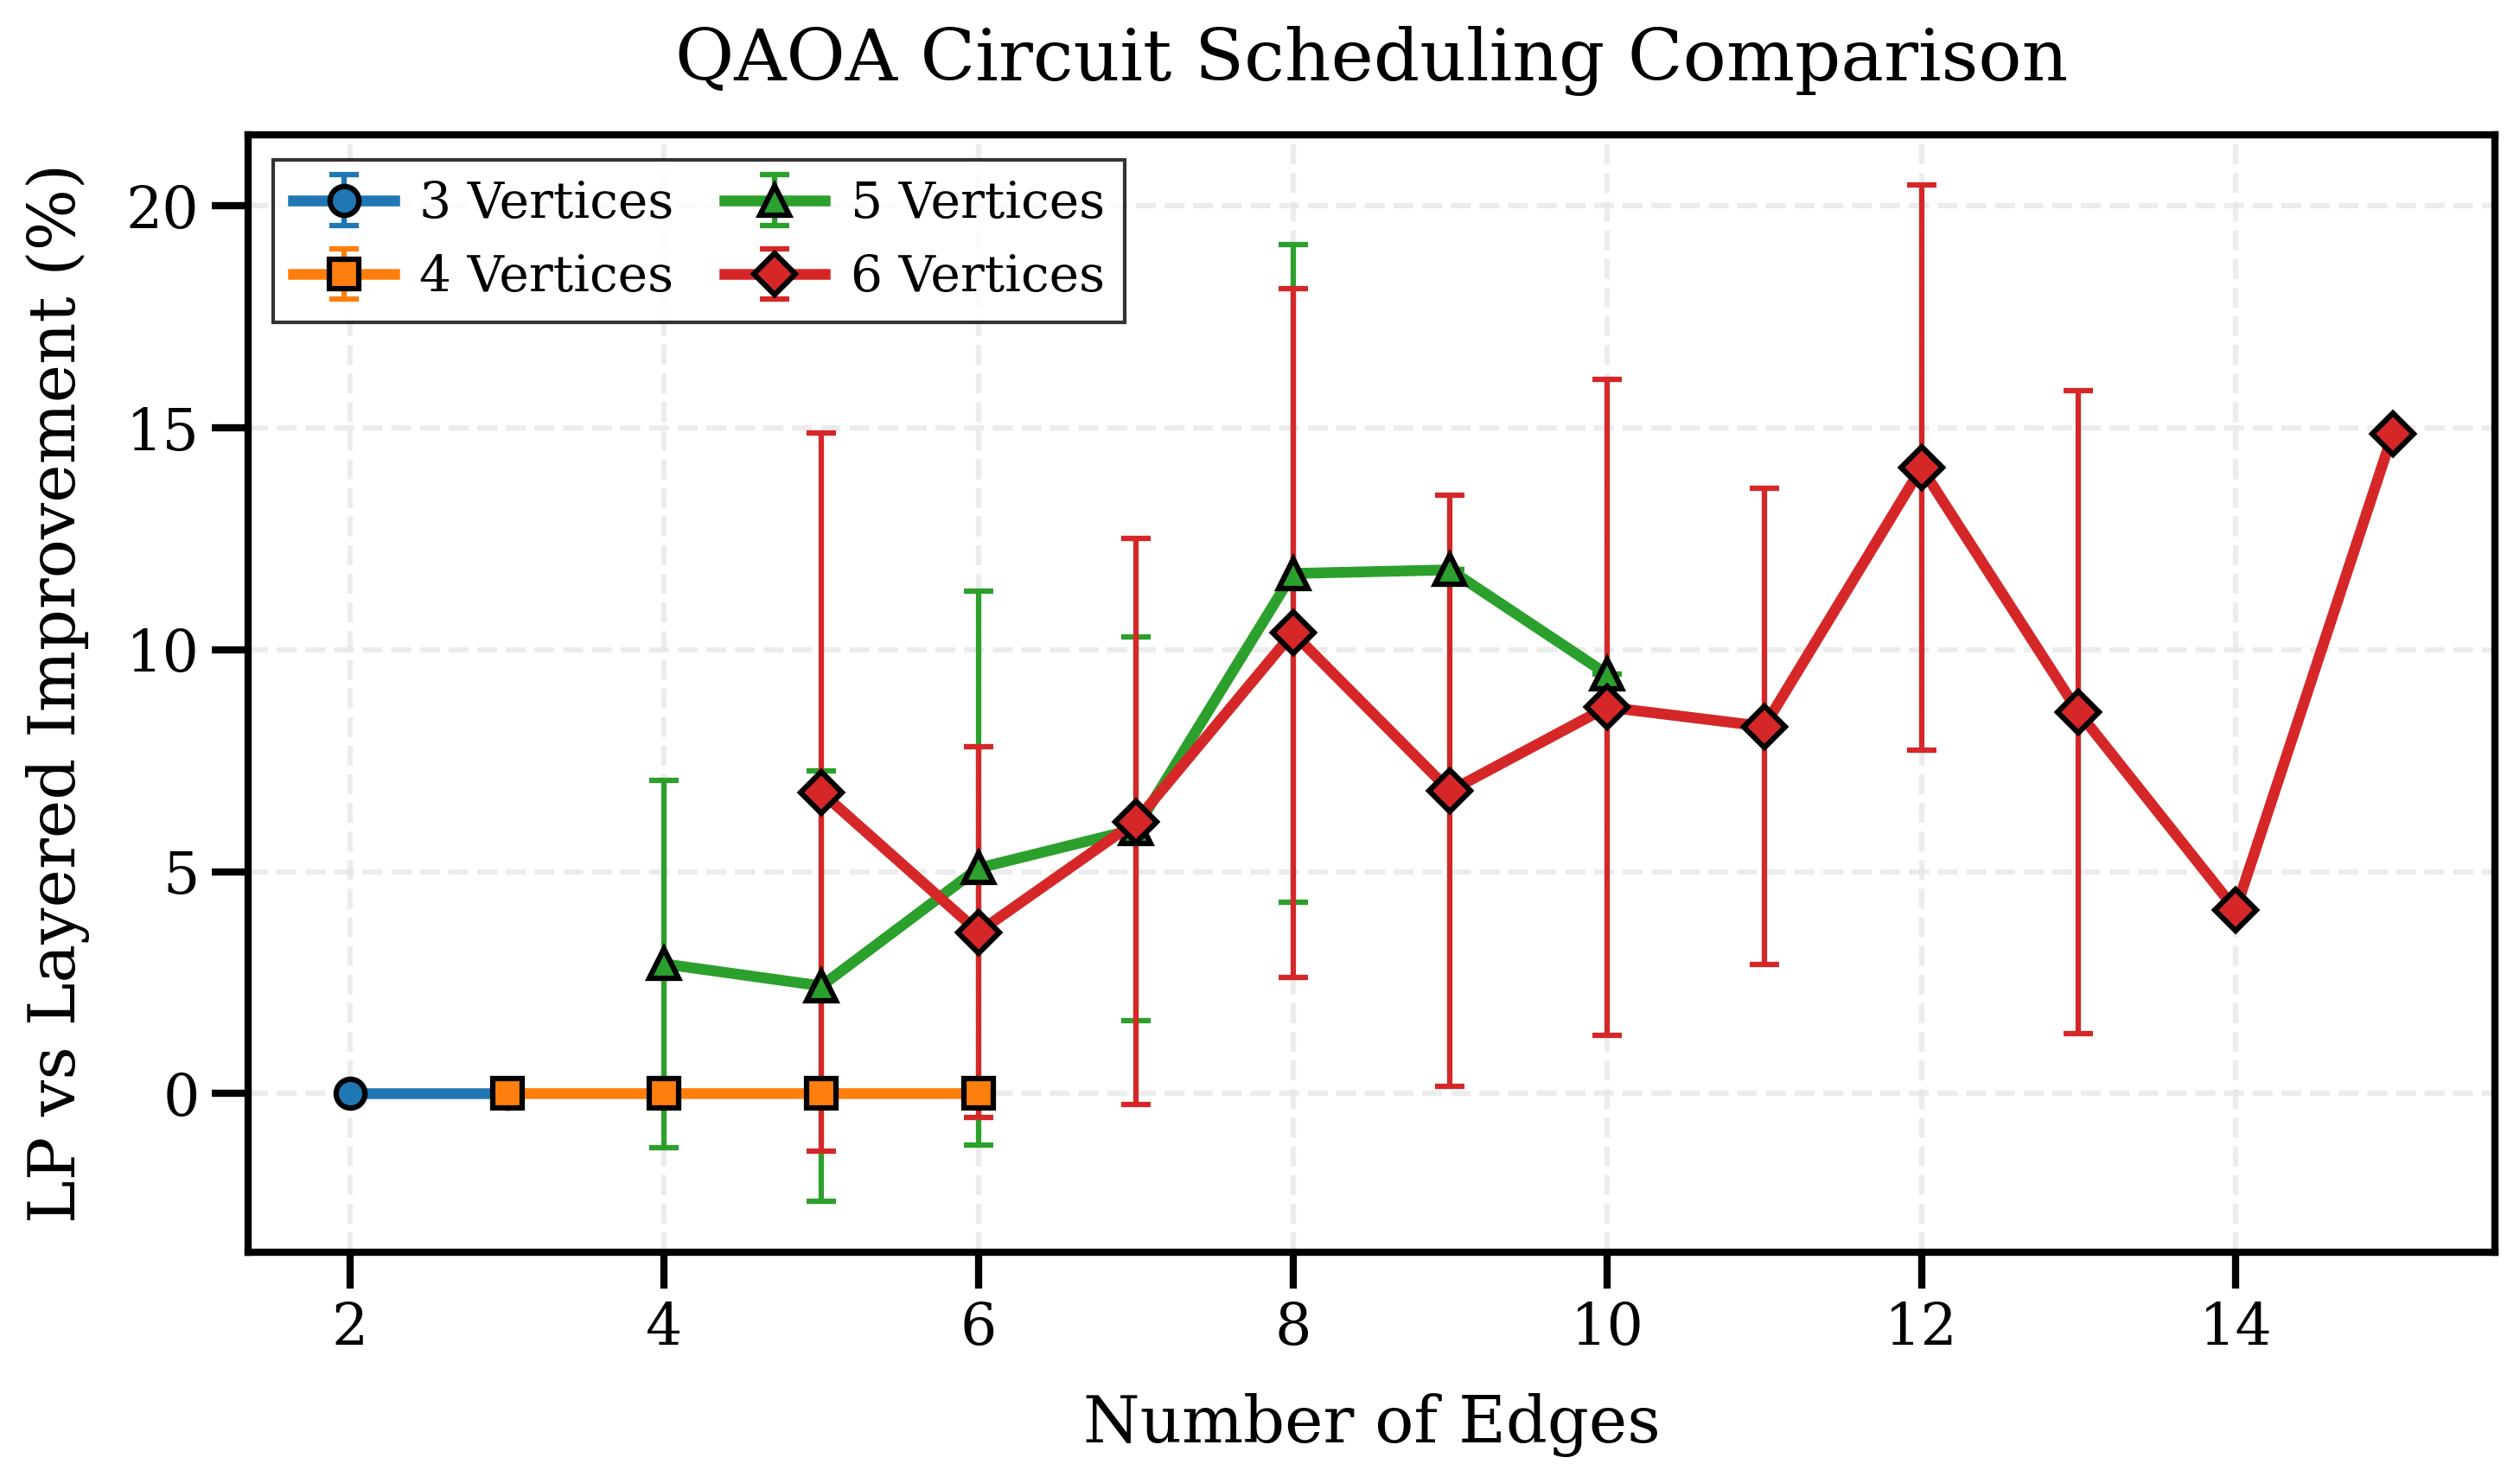

In [4]:
# Example usage:
# First, compute and save all results
compute_all_results(vertex_range=(3, 6), n_samples=1000)
plot_from_saved_results(vertex_range=(3, 6), n_samples=1000)